In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from gensim.models import KeyedVectors
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
sns.set_theme()

In [3]:
DATA_ROOT = "../../data/v2/"

In [4]:
chive = KeyedVectors.load(
    DATA_ROOT + "chive-1.1-mc5-aunit_gensim/chive-1.1-mc5-aunit.kv"
)

In [5]:
train_ds = torch.load(DATA_ROOT + "train_ds.pth")
val_ds = torch.load(DATA_ROOT + "val_ds.pth")
test_ds = torch.load(DATA_ROOT + "test_ds.pth")

In [6]:
train_ds

In [7]:
val_ds

In [8]:
test_ds

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
PADDED_LEN = 128
VOCAB_SIZE = len(chive.key_to_index) + 2
EMBEDDING_DIM = chive.vector_size
embed_weights = np.vstack([np.zeros((2, EMBEDDING_DIM)), chive.vectors])
embeds = nn.Embedding.from_pretrained(torch.tensor(embed_weights, dtype=torch.float32)).to(device)

In [11]:
class AttentionClassifier(nn.Module):
    def __init__(
        self,
        embeds: nn.Embedding,
        n_classes: int,
        attention_da: int = 128,
        seq_hidden_dim: int = 256,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        embed_dim = embeds.embedding_dim
        self.embeds = embeds
        self.bilstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=embed_dim,
            batch_first=True,
            bidirectional=True,
        )
        self.attention = nn.Sequential(
            nn.Linear(2 * embed_dim, attention_da),
            nn.ReLU(),
            nn.Linear(attention_da, n_classes),
            nn.Softmax(dim=1),
        )
        self.sequence = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_classes * 2 * embed_dim, seq_hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(seq_hidden_dim),
            nn.Linear(seq_hidden_dim, n_classes),
        )

    def forward(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        X = self.embeds(X)
        X, _ = self.bilstm(X)
        attention = self.attention(X)
        X = torch.transpose(attention, 1, 2) @ X
        X = self.sequence(X)
        return X, attention

In [12]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    n_batch_report: int = 10,
) -> tuple[float, float]:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        optimizer.zero_grad()
        y_pred, _ = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        if i % n_batch_report == 0:
            loss, current = loss.item(), (i + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size

    return train_loss, correct


def test(
    model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module
) -> tuple[float, float]:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred, _ = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [13]:
class EarlyStopping:
    def __init__(self, patience: int = 7, delta: float = 0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None

    def __call__(self, score: float):
        early_stop = False
        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                early_stop = True
        else:
            self.best_score = min(score, self.best_score)
            self.counter = 0
        return early_stop

In [14]:
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [15]:
lr = 1e-3
N_CLASSES = 2
model = AttentionClassifier(embeds, N_CLASSES).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [16]:
model

AttentionClassifier(
  (embeds): Embedding(322096, 300)
  (bilstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
  (sequence): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1200, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [17]:
X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)

X = model.embeds(X)
print(X.shape)
X, _ = model.bilstm(X)
print(X.shape)
attention = model.attention(X)
print(attention.shape)
X = torch.transpose(attention, 1, 2) @ X
print(X.shape)
X = model.sequence(X)
print(X.shape)

torch.Size([256, 128, 300])
torch.Size([256, 128, 600])
torch.Size([256, 128, 2])
torch.Size([256, 2, 600])
torch.Size([256, 2])


In [18]:
X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)

y_pred, attention = model(X)
y_pred.shape, attention.shape

(torch.Size([256, 2]), torch.Size([256, 128, 2]))

In [19]:
epoch_total = 0
hist = {"train_loss": [], "train_accuracy": [], "val_loss": [], "val_accuracy": []}
early_stopping = EarlyStopping(patience=3)
summary_writer = SummaryWriter(log_dir="./logs")

In [22]:
N_EPOCHS = 10
for t in range(N_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_accuracy = test(model, val_loader, loss_fn)

    hist["train_loss"].append(train_loss)
    hist["train_accuracy"].append(train_accuracy)
    hist["val_loss"].append(val_loss)
    hist["val_accuracy"].append(val_accuracy)
    summary_writer.add_scalars("loss", {"train": train_loss, "val": val_loss}, epoch_total)
    summary_writer.add_scalars("accuracy", {"train": train_accuracy, "val": val_accuracy}, epoch_total)

    print("Epoch Summary:")
    print(f"train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
    print(f"train_accuracy: {train_accuracy:>7f}, val_accuracy: {val_accuracy:>7f}")

    if early_stopping(val_loss):
        print("Early stopping")
        break
    
    epoch_total += 1

Epoch 1
-------------------------------
loss: 0.697123  [  256/34560]
loss: 0.635737  [ 2816/34560]
loss: 0.597062  [ 5376/34560]
loss: 0.565633  [ 7936/34560]
loss: 0.609372  [10496/34560]
loss: 0.594836  [13056/34560]
loss: 0.515119  [15616/34560]
loss: 0.602030  [18176/34560]
loss: 0.547721  [20736/34560]
loss: 0.520428  [23296/34560]
loss: 0.535011  [25856/34560]
loss: 0.544561  [28416/34560]
loss: 0.509417  [30976/34560]
loss: 0.493740  [33536/34560]
Epoch Summary:
train_loss: 0.561433, val_loss: 0.808060
train_accuracy: 0.716725, val_accuracy: 0.654282
Epoch 2
-------------------------------
loss: 0.490332  [  256/34560]
loss: 0.564021  [ 2816/34560]
loss: 0.516615  [ 5376/34560]
loss: 0.490165  [ 7936/34560]
loss: 0.551045  [10496/34560]
loss: 0.483302  [13056/34560]
loss: 0.490608  [15616/34560]
loss: 0.496648  [18176/34560]
loss: 0.495427  [20736/34560]
loss: 0.489542  [23296/34560]
loss: 0.533081  [25856/34560]
loss: 0.548705  [28416/34560]
loss: 0.490447  [30976/34560]
loss:

In [24]:
now = datetime.datetime.now()
time_stamp = now.strftime("%Y%m%d_%H%M")
torch.save(model.state_dict(), DATA_ROOT + f"/models/{time_stamp}.pth")
torch.save(optimizer.state_dict(), DATA_ROOT + f"/models/{time_stamp}_optim.pth")

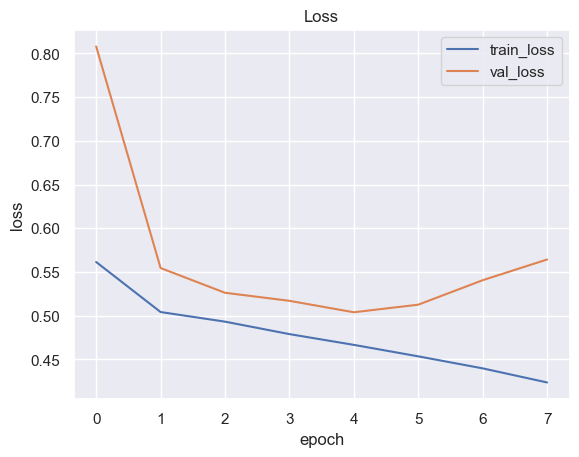

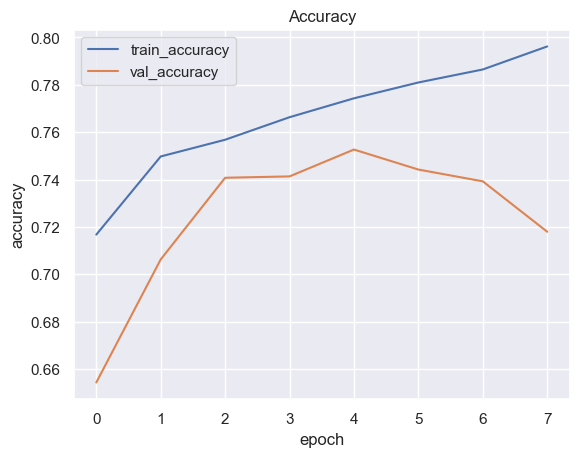

In [25]:
plt.plot(hist["train_loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(hist["train_accuracy"], label="train_accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [26]:
test_loss, test_accuracy = test(model, test_loader, loss_fn)
print(f"Test Loss: {test_loss:>7f}")
print(f"Test Accuracy: {test_accuracy:>7f}")

Test Loss: 0.186342
Test Accuracy: 0.921429


In [20]:
%load_ext tensorboard

In [21]:
%tensorboard --logdir ./logs/